<a href="https://colab.research.google.com/github/delinayetbarek03/StatsC261-Midterm/blob/main/GaussianCopulaSynthesizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount your own google drive to Colab
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set the path to your specific folder
folder_path = '/content/drive/My Drive/STATS261_Final/tvae'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install sdv

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report
import pickle
from sdv.single_table import TVAESynthesizer
from sdv.metadata import SingleTableMetadata
from sdv.metadata import Metadata

In [ ]:
# Load original dataset
# Path to the CSV file
file_path = '/content/drive/My Drive/STATS261_Final/tvae/train_data_ads.csv'

# Load the CSV into a DataFrame
og_ds = pd.read_csv(file_path)

In [ ]:
# MT STUFF

# Separate the target and selected features
gender = og_ds['gender']
selected_features = [ 'city', 'age', 'series_group', 'emui_dev', 'residence']
features_for_model = og_ds[selected_features]

features = ['city', 'age', 'series_group', 'emui_dev', 'residence', 'gender']
ds_best = og_ds[features]

# Split data into training and testing sets (70-30 split)
X_train, X_test, y_train, y_test = train_test_split(features_for_model, gender, test_size=0.3, random_state=42)

# Define the preprocessor with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age']),  # Standardize numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['city'])  # One-hot encode categorical features
    ]
)

# Build the full pipeline with SGDClassifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SGDClassifier(loss='hinge', max_iter=1000, tol=0.001, random_state=42))
])

# Train the model on REAL DATA
pipeline.fit(X_train, y_train)

# Make predictions on REAL TEST DATA
y_pred_real = pipeline.predict(X_test)

# Using GaussianCopulaSynthesizer!!

In [ ]:
from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer
from sklearn.linear_model import SGDClassifier
import pandas as pd
import pickle
import time

# Prepare metadata
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(ds_best)

# Update column types
column_types = {
    'city': 'numerical',
    'series_group': 'numerical',
    'emui_dev': 'numerical',
    'residence': 'numerical',
    'age': 'numerical',
    'gender': 'categorical'
}

# Apply column type updates
for col, sdtype in column_types.items():
    metadata.update_column(col, sdtype=sdtype)

# Combine training data
train_data = pd.concat([X_train, y_train], axis=1)

# Initialize Gaussian Copula Synthesizer
gc_synthesizer = GaussianCopulaSynthesizer(metadata)

# Time the fitting process
start_time = time.time()

# Fit the synthesizer
gc_synthesizer.fit(train_data)

end_time = time.time()
print(f"Total fitting time: {end_time - start_time} seconds")

# Generate synthetic data
synthetic_data = gc_synthesizer.sample(num_rows=len(train_data))

# Separate features and target
synthetic_X = synthetic_data.drop(columns=["gender"])
synthetic_y = synthetic_data['gender']

# Train SGDClassifier on synthetic data
sgd_synth = SGDClassifier(
    random_state=42,
    n_jobs=-1,  # Use all available cores
    max_iter=1000,
    tol=1e-3
)

sgd_synth.fit(synthetic_X, synthetic_y)

# Save the model
with open('sgd_gc_SYNTH.pkl', 'wb') as file:
    pickle.dump(sgd_synth, file)

# Evaluate on test data
y_pred_synth = sgd_synth.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sdv/single_table/base.py:119: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.10/dist-packages/sdv/single_table/base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Total fitting time: 839.1056125164032 seconds


# combo

In [ ]:
# FINAL STUFF: SYNTHETIC + REAL DATA GENERATION


# Combine synthetic and real data for training
X_train_combined = pd.concat([X_train, synthetic_X])
y_train_combined = pd.concat([y_train, synthetic_y])

# Train SGDClassifier on combined data
sgd_combo = SGDClassifier(random_state=42)
sgd_combo.fit(X_train_combined, y_train_combined)

# Save the model trained on combined data
with open('sgd_tvae_COMBO.pkl', 'wb') as file:
    pickle.dump(sgd_combo, file)

# Evaluate COMBINED MODEL performance on REAL TEST DATA
y_pred_combo = sgd_combo.predict(X_test)

# METRICS --> Utility

In [ ]:
# METRICS FOR REAL DATA

# Generate and print classification report for real predictions
print("Classification Report for Real Data Predictions:")
report_real = classification_report(y_test, y_pred_real, target_names=['Gender Class 2', 'Gender Class 3', 'Gender Class 4'])
print(report_real)

real_data_accuracy = accuracy_score(y_test, y_pred_real)
print(f"Real Data Accuracy: {real_data_accuracy:.2f}")

Classification Report for Real Data Predictions:
                precision    recall  f1-score   support

Gender Class 2       0.89      0.99      0.94   1783794
Gender Class 3       0.43      0.00      0.01    164794
Gender Class 4       0.95      0.85      0.89    354068

      accuracy                           0.90   2302656
     macro avg       0.76      0.61      0.61   2302656
  weighted avg       0.87      0.90      0.86   2302656

Real Data Accuracy: 0.90


In [ ]:
# METRICS FOR SYNTHETIC DATA

from sklearn.metrics import classification_report, accuracy_score

# Check class distributions
print("Class distribution in y_test:")
print(y_test.value_counts())

print("Class distribution in y_pred_synth:")
print(pd.Series(y_pred_synth).value_counts())

# Generate classification report
print("Classification Report for Synthetic Data Predictions:")
report_tvae_synth = classification_report(
    y_test,
    y_pred_synth,
    target_names=['Gender Class 2', 'Gender Class 3', 'Gender Class 4'],
    zero_division=0  # Handle undefined metrics
)
print(report_tvae_synth)

# Calculate accuracy
accuracy_tvae_synth = accuracy_score(y_test, y_pred_synth)
print(f"Synthetic Data Accuracy: {accuracy_tvae_synth:.2f}")


Class distribution in y_test:
gender
2    1783794
4     354068
3     164794
Name: count, dtype: int64
Class distribution in y_pred_synth:
2    2302656
Name: count, dtype: int64
Classification Report for Synthetic Data Predictions:
                precision    recall  f1-score   support

Gender Class 2       0.77      1.00      0.87   1783794
Gender Class 3       0.00      0.00      0.00    164794
Gender Class 4       0.00      0.00      0.00    354068

      accuracy                           0.77   2302656
     macro avg       0.26      0.33      0.29   2302656
  weighted avg       0.60      0.77      0.68   2302656

Synthetic Data Accuracy: 0.77


In [ ]:
# METRICS FOR COMBO: REAL + SYNTHETIC DATA


from sklearn.metrics import classification_report, accuracy_score

# Class distribution
print("Class distribution in y_test:")
print(y_test.value_counts())

print("Class distribution in y_pred_combo:")
print(pd.Series(y_pred_combo).value_counts())

# Generate classification report
print("Classification Report for Combined Data Predictions:")
report_tvae_combo = classification_report(
    y_test,
    y_pred_combo,
    target_names=['Gender Class 2', 'Gender Class 3', 'Gender Class 4'],
    zero_division=0  # Handle undefined metrics
)
print(report_tvae_combo)

# Calculate accuracy
accuracy_tvae_combo = accuracy_score(y_test, y_pred_combo)
print(f"Combined Data Accuracy: {accuracy_tvae_combo:.2f}")


Class distribution in y_test:
gender
2    1783794
4     354068
3     164794
Name: count, dtype: int64
Class distribution in y_pred_combo:
2    2300446
4       2210
Name: count, dtype: int64
Classification Report for Combined Data Predictions:
                precision    recall  f1-score   support

Gender Class 2       0.77      1.00      0.87   1783794
Gender Class 3       0.00      0.00      0.00    164794
Gender Class 4       0.28      0.00      0.00    354068

      accuracy                           0.77   2302656
     macro avg       0.35      0.33      0.29   2302656
  weighted avg       0.64      0.77      0.68   2302656

Combined Data Accuracy: 0.77


# define vars

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, label_binarize
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize
from scipy.special import softmax
import matplotlib.pyplot as plt
import numpy as np

# UTILITY: Multi-class ROC curve

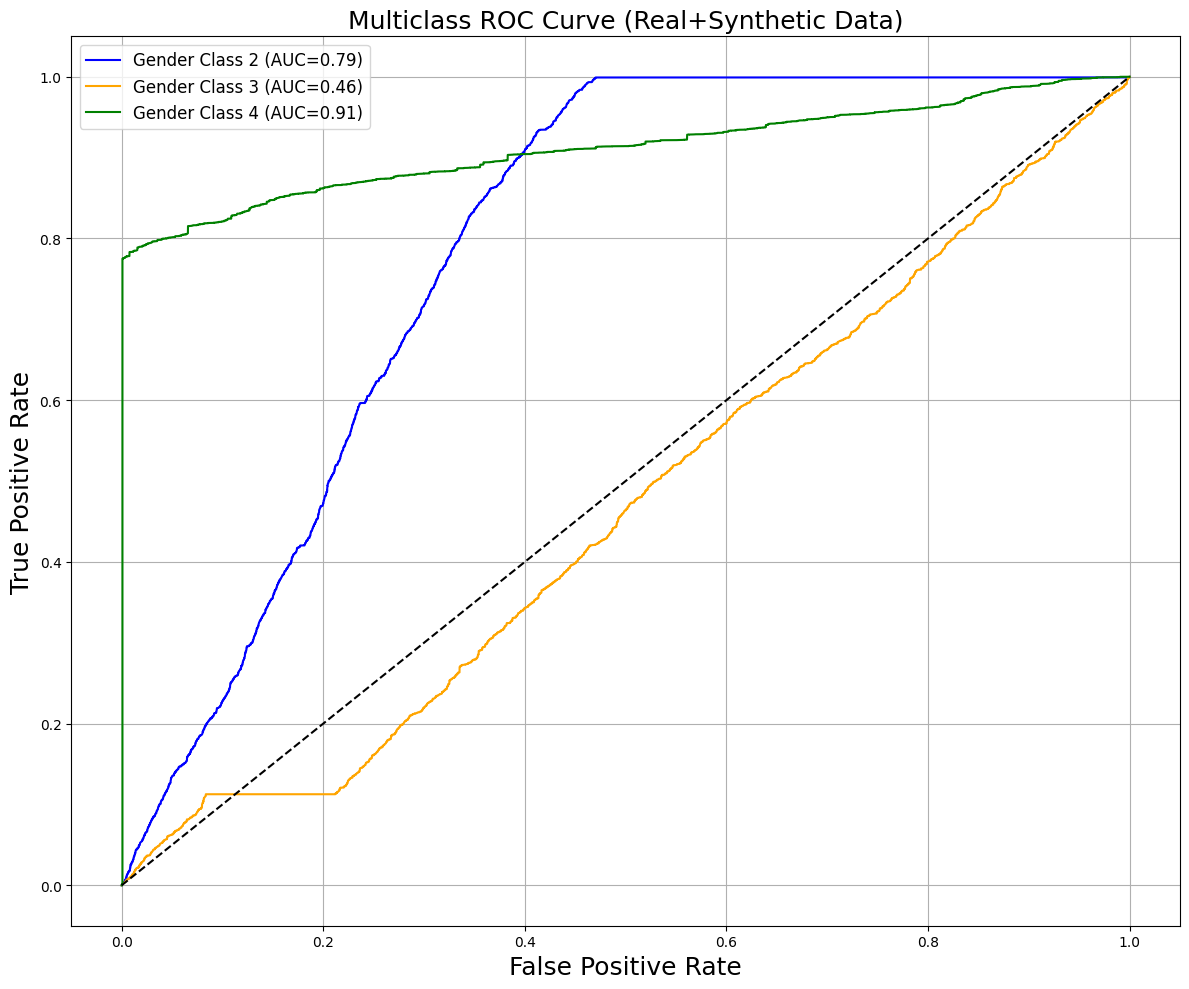

In [ ]:
# COMBO: REAL + SYNTHETIC

# Get decision function scores
raw_scores = sgd_combo.decision_function(X_test)

# Convert decision scores to probabilities using softmax
y_pred_proba = softmax(raw_scores, axis=1)

# Binarize the labels for ROC curve
y_test_binary = label_binarize(y_test, classes=np.unique(y_test))  # Ensure correct classes

# Multiclass ROC Curve
plt.figure(figsize=(12, 10))

n_classes = y_test_binary.shape[1]
colors = ['blue', 'orange', 'green']  # Adjust colors for classes

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binary[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Gender Class {i + 2} (AUC={roc_auc:.2f})', color=colors[i])

# Add diagonal line for random chance
plt.plot([0, 1], [0, 1], 'k--')

# Add plot details
plt.title('Multiclass ROC Curve (Real+Synthetic Data)', fontsize=18)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.legend(loc='best', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# FIDELITY: Correlation plot

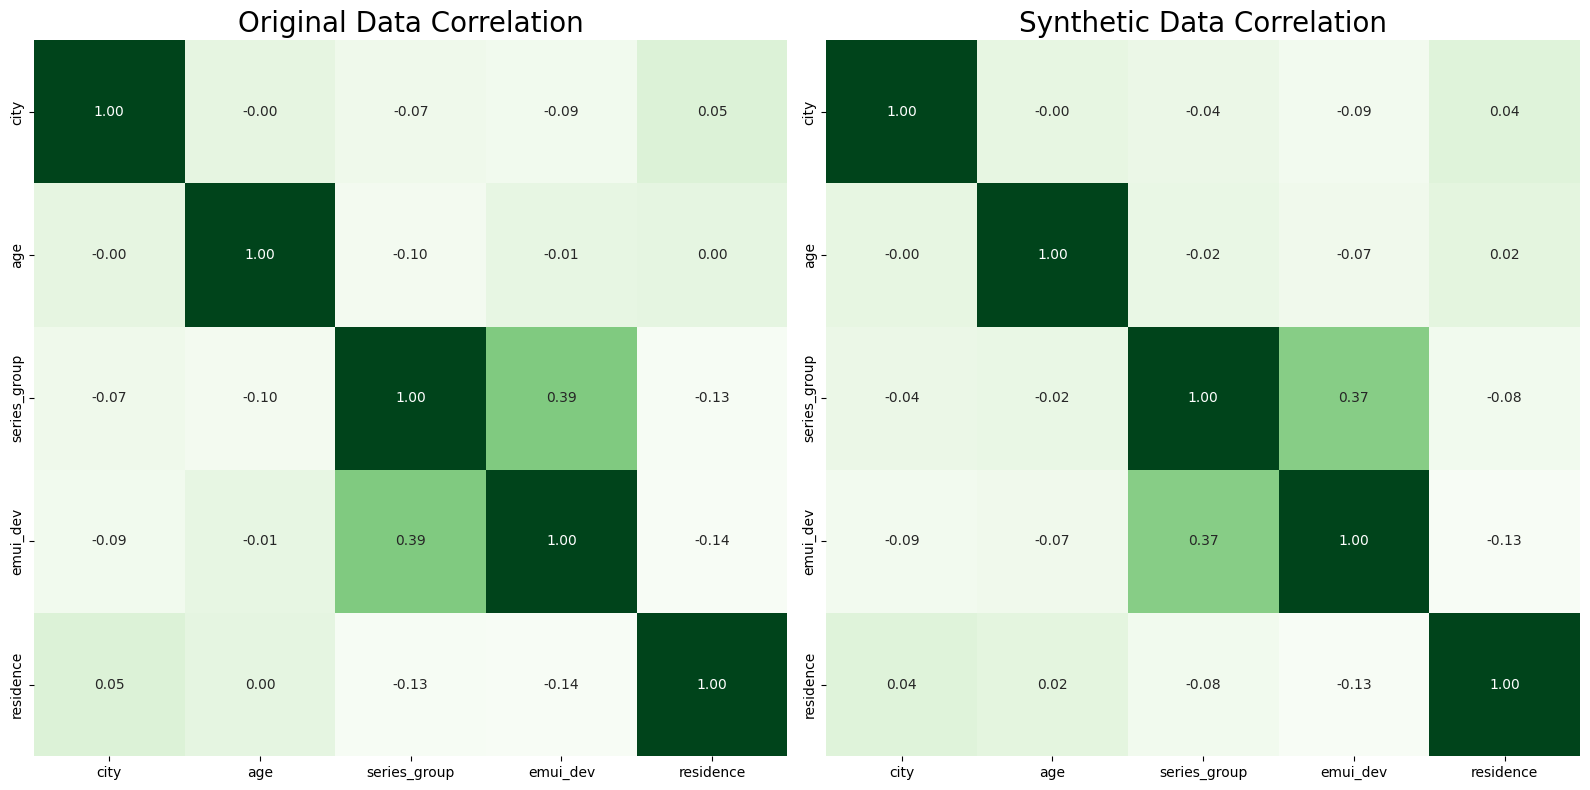

In [ ]:
# Comparing data correlations between original and synthetic - Fidelity

import seaborn as sns

corr_original = X_train.corr()
corr_synthetic = synthetic_X.corr()

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.heatmap(
    corr_original,
    ax=ax[0],
    cmap='Greens',
    cbar=False,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 10}
)
ax[0].set_title('Original Data Correlation', fontsize=20)

sns.heatmap(
    corr_synthetic,
    ax=ax[1],
    cmap='Greens',
    cbar=False,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 10}
)
ax[1].set_title('Synthetic Data Correlation', fontsize=20)

plt.tight_layout()
plt.show()

# PRIVACY: ROC Curve for Unsupervised Membership Inference Attack

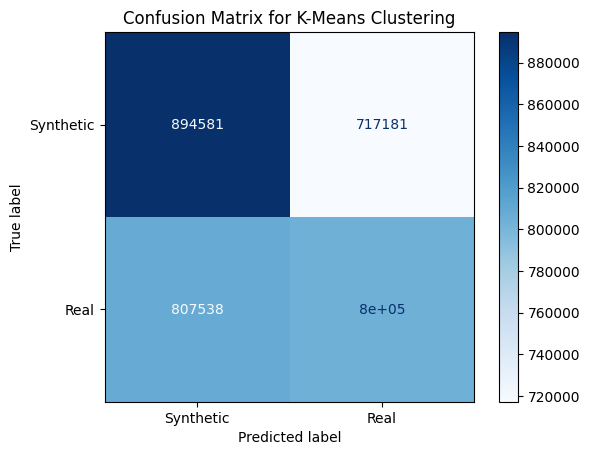

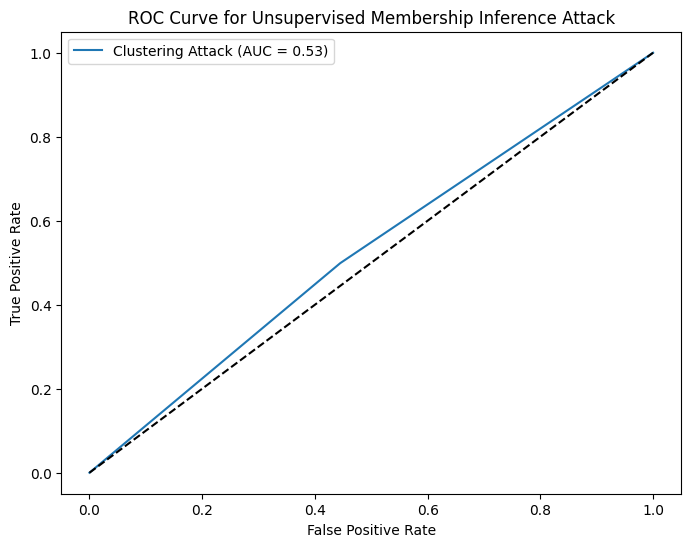

Precision: 0.53
Recall: 0.50
Accuracy: 0.53
F1-Score: 0.51
AUC for Unsupervised Privacy Attack: 0.53


In [ ]:
## Privacy - Unsupervised

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, roc_curve, auc, precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Combine real and synthetic data
combined_data = pd.concat([X_train, synthetic_X])
labels = np.concatenate([np.ones(len(X_train)), np.zeros(len(synthetic_X))])  # 1 for real, 0 for synthetic

# Scale the data for better clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(combined_data)

# Split into train and test
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(scaled_data, labels, test_size=0.3, random_state=42)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train_split)

# Predict on the test data
cluster_labels_test = kmeans.predict(X_test_split)

# Map clusters to original labels based on the training data
mapping = {}
for cluster in range(2):  # For each cluster
    # Majority label in this cluster
    majority_label = int(np.round(y_train_split[kmeans.labels_ == cluster].mean()))
    mapping[cluster] = majority_label

# Assign predictions based on cluster mapping
predicted_labels_test = np.array([mapping[label] for label in cluster_labels_test])

# Evaluate performance metrics
precision = precision_score(y_test_split, predicted_labels_test)
recall = recall_score(y_test_split, predicted_labels_test)
accuracy = accuracy_score(y_test_split, predicted_labels_test)
f1 = f1_score(y_test_split, predicted_labels_test)
fpr, tpr, _ = roc_curve(y_test_split, predicted_labels_test)
roc_auc = auc(fpr, tpr)

# Confusion Matrix
cm = confusion_matrix(y_test_split, predicted_labels_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Synthetic", "Real"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for K-Means Clustering")
plt.show()

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Clustering Attack (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Unsupervised Membership Inference Attack')
plt.legend()
plt.show()

# Print results
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Accuracy: {accuracy:.2f}')  # New
print(f'F1-Score: {f1:.2f}')
print(f'AUC for Unsupervised Privacy Attack: {roc_auc:.2f}')